In [1]:
import numpy as np
import matplotlib.pyplot as plt

from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from aeons.covariance import X_mu, X_Sigmainv, logX_mu, points_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from aeons.models import LS, CG

In [40]:
format = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 11pt font in plots, to match 11pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    'axes.linewidth': 0.5,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'patch.linewidth': 0.5,
    'legend.fancybox': False,
    'legend.shadow': False
}
plt.rcParams.update(format)

When nk large, enough points so that least squares fit pretty much balances out with stochastic mean on each side.

So mean vs least squares become basically equivalent for high nk

Much better for low nk

In [2]:
def plot_points(L, X, ndead):
    plt.plot(X[:ndead], L[:ndead], 'x', ms=1)
    plt.plot(X[ndead:], L[ndead:], 'x', ms=1)

def Z(L, X):
    return -np.trapz(L, X)

#### **Plots of endpoint prediction**

In [3]:
from aeons.lm_partial import analytic_lm_params, X_end_formula

In [76]:
samples = samples_g_1
nlive = 500
epsilon = 1e-3
X_end_true = X_end_formula(10, 0.1, epsilon)
endpoint_true = np.log(X_end_true) * (-nlive)
endpoint_true

10840.18928167041

##### Smoothed using live points only

In [113]:
iterations = np.arange(500, 10800, 200)
endpoint_predictions = []
for i, iteration in enumerate(iterations):
    points = points_at_iteration(samples, iteration)
    logL = np.array(points.logL)[iteration:]
    logX_mean = np.array(points.logX())[iteration:]
    X_mean = np.exp(logX_mean)
    _, d, sigma = analytic_lm_params(logL, np.exp(logX_mean), 10)
    X_end = X_end_formula(d, sigma, 0.001)
    logX_end = np.log(X_end)
    endpoint = logX_end * (-nlive)
    endpoint_predictions.append(endpoint)

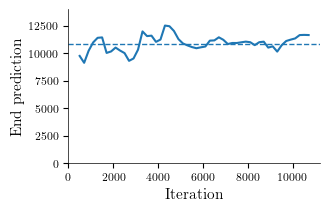

In [114]:
plt.figure(figsize=(3.25,2))
plt.plot(iterations, endpoint_predictions)
plt.axhline(y=endpoint_true, ls='--', lw=1)
plt.ylim(0, 14000)
plt.xlabel('Iteration')
plt.ylabel('End prediction')
plt.savefig('../../../report/figures/endpoints_live.pdf', format='pdf', bbox_inches='tight')

##### Smoothed using bandwith selection

In [115]:
iterations = np.arange(200, 10800, 400)
alphas = np.arange(0, 1, 0.05)
endpoint_predictions = []
for i, iteration in enumerate(iterations):
    points = points_at_iteration(samples, iteration)
    logL = np.array(points.logL)
    X_mean = np.exp(np.array(points.logX()))
    theta_best = None
    logZi = -np.inf
    alpha_best = 0
    for alpha in alphas:
        startf = int(iteration * (1 - alpha))
        logLf = logL[startf:]
        X_meanf = X_mean[startf:]
        lsf = LS(logLf, full, X_meanf)
        thetaf = analytic_lm_params(logLf, X_meanf, 10)
        penalty = startf * np.log(startf) - startf if startf != 0 else 0
        logZf = lsf.logZ(thetaf) - penalty
        if logZf > logZi:
            theta_best = thetaf
            alpha_best = alpha
    print(iteration, alpha_best, theta_best)
    _, d, sigma = theta_best
    X_end = X_end_formula(d, sigma, 0.001)
    logX_end = np.log(X_end)
    endpoint = logX_end * (-nlive)
    endpoint_predictions.append(endpoint)

200 0.9500000000000001 [0.20627071485496629, 9.363551619929876, 0.09989374870752736]
600 0.9500000000000001 [-1.7667675265540197, 9.046216844351676, 0.10199683028501598]
1000 0.9500000000000001 [-1.8728714326113263, 9.193239022524905, 0.10225663850013528]
1400 0.9500000000000001 [-0.3398675469844932, 9.630074151446856, 0.10076579271912572]
1800 0.9500000000000001 [-0.26103783541896064, 9.710513411013906, 0.1007596452504444]
2200 0.9500000000000001 [0.33343650526058966, 9.921870490706326, 0.10024967013891514]
2600 0.9500000000000001 [0.17748906972569856, 9.869441035546489, 0.10039676441235902]
3000 0.9500000000000001 [-0.2898680635769715, 9.714737616116873, 0.10082294249304466]
3400 0.9500000000000001 [-0.36090711674907894, 9.696609173812869, 0.10090181257407552]
3800 0.9500000000000001 [-0.22219031744402784, 9.75522782012064, 0.10080398958516014]
4200 0.9500000000000001 [-0.5119120053320145, 9.645056231333731, 0.10104313537087382]
4600 0.9500000000000001 [-0.5373533708248743, 9.6422425

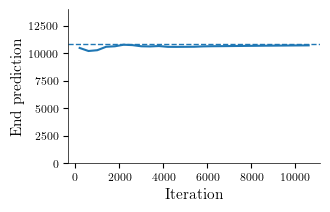

In [116]:
plt.figure(figsize=(3.25,2))
plt.plot(iterations, endpoint_predictions)
plt.axhline(y=endpoint_true, ls='--', lw=1)
plt.ylim(0, 14000)
plt.xlabel('Iteration')
plt.ylabel('End prediction');
plt.savefig('../../../report/figures/endpoints_bandwidth.pdf', format='pdf', bbox_inches='tight')

##### Normal nested sampling

### **Comparison of Z using mean vs smoothed X**

In [151]:
ndead = 500
nlive = 100
nk = nk_dead_live(nlive, ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)

In [13]:
from scipy.integrate import quad

def gaussian_L(X, theta):
    d, sigma = theta
    return np.exp(-X**(2/d)/(2*sigma**2))

Ztrue = quad(gaussian_L, 0, 1, [10, 0.1])[0]
Ztrue, np.log(Ztrue)

(3.839461497722952e-07, -14.772763529160507)

In [4]:
def H_gaussian_L(X, theta):
    L = gaussian_L(X, theta)
    return L/Ztrue * np.log(L/Ztrue)
H = quad(H_gaussian_L, 0, 1, [10, 0.1])[0]
H

9.774134204558328

In [337]:
ndead = 1000
nlive = 50
nk = nk_dead_live(nlive, ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)

In [338]:
X = generate_Xs(nk)
Xdead, Xlive = X[:ndead], X[ndead:]
logX = np.log(X)
theta_true = [10, 0.1]
logL = middle.func(X, theta_true)
L = np.exp(logL)
logLdead, logLlive = logL[:ndead], logL[ndead:]
Ldead, Llive = np.exp(logLdead), np.exp(logLlive)

ls = LS(logL[ndead:], middle, X_mean[ndead:])
theta_l = ls.minimise(theta_true)
X_l = middle.inverse(logL, theta_l)
logX_l = np.log(X_l)

In [342]:
np.sqrt(1/5)

0.4472135954999579

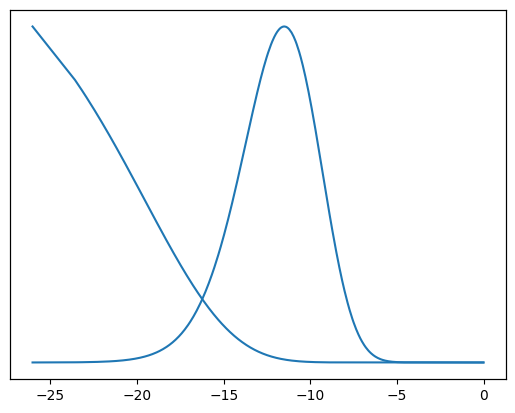

In [341]:
fig, ax1 = plt.subplots()
ax2 = plt.twinx(ax1)
ax1.plot(logX, L)
ax2.plot(logX, L*X)
for ax in fig.axes:
    ax.set_yticks([])

In [371]:
ndead = 5000
nlive = 500
nk = nk_dead_live(nlive, ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)

Text(0.5, 0.98, 'ndead=5000, nlive=500')

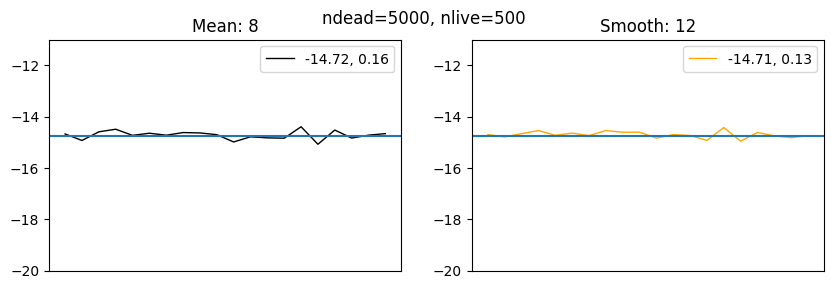

In [374]:
logZmeans = []
logZsmooths = []
smooths = 0
means = 0
for _ in range(20):
    X = generate_Xs(nk)
    Xdead, Xlive = X[:ndead], X[ndead:]
    logX = np.log(X)
    theta_true = [10, 0.1]
    logL = middle.func(X, theta_true)
    L = np.exp(logL)
    logLdead, logLlive = logL[:ndead], logL[ndead:]
    Ldead, Llive = np.exp(logLdead), np.exp(logLlive)
    
    ls = LS(logL[ndead:], middle, X_mean[ndead:])
    theta_l = ls.minimise(theta_true)
    X_l = middle.inverse(logL, theta_l)
    logX_l = np.log(X_l)

    Zdead = Z(Ldead, X_mean[:ndead])
    Zlive_mean = Z(Llive, X_mean[ndead:])
    Zlive_smooth = quad(gaussian_L, 0, Xlive[0], theta_l)[0]
    logZmean = np.log(Zdead + Zlive_mean)
    logZmeans.append(logZmean)
    logZsmooth = np.log(Zdead + Zlive_smooth)
    logZsmooths.append(logZsmooth)
    if abs(logZsmooth - np.log(Ztrue)) < abs(logZmean - np.log(Ztrue)):
        smooths += 1
    else:
        means += 1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
ax1.plot(logZmeans, lw=1, color='black', label=f"{np.mean(logZmeans):.2f}, {np.std(logZmeans):.2f}")
ax2.plot(logZsmooths, lw=1, color='orange', label=f"{np.mean(logZsmooths):.2f}, {np.std(logZsmooths):.2f}")
ax1.set_title(f"Mean: {means}")
ax2.set_title(f"Smooth: {smooths}")
for ax in [ax1, ax2]:
    ax.axhline(np.log(Ztrue))
    ax.set_ylim(-20, -11)
    ax.set_xticks([])
    ax.legend()
fig.suptitle(f"ndead={ndead}, nlive={nlive}")

In [21]:
ndead = 500
nlive = 100
nk = nk_dead_live(nlive, ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)

Text(0.5, 0.98, 'ndead=500, nlive=100')

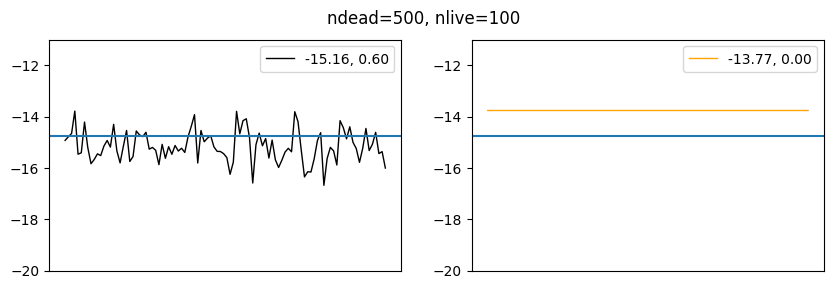

In [33]:
# Monte Carlo over t done properly
X_true = generate_Xs(nk)
logX_true = np.log(X_true)
theta_true = [10, 0.1]
logL = middle.func(X_true, theta_true)
L = np.exp(logL)
Ldead, Llive = L[:ndead], L[ndead:]

logZmeans = []
logZsmooths = []

for _ in range(100):
    X = generate_Xs(nk)
    Xdead, Xlive = X[:ndead], X[ndead:]
    ls = LS(logL[ndead:], middle, X_mean[ndead:])
    theta_l = ls.minimise(theta_true)

    Zdead = Z(Ldead, X[:ndead])
    Zlive_mean = Z(Llive, X[ndead:])
    Zlive_smooth = quad(gaussian_L, 0, Xlive[0], theta_l)[0]
    logZmean = np.log(Zdead + Zlive_mean)
    logZmeans.append(logZmean)
    logZsmooth = np.log(Zdead + Zlive_smooth)
    logZsmooths.append(logZsmooth)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
ax1.plot(logZmeans, lw=1, color='black', label=f"{np.mean(logZmeans):.2f}, {np.std(logZmeans):.2f}")
ax2.plot(logZsmooths, lw=1, color='orange', label=f"{np.mean(logZsmooths):.2f}, {np.std(logZsmooths):.2f}")
for ax in [ax1, ax2]:
    ax.axhline(np.log(Ztrue))
    ax.set_ylim(-20, -11)
    ax.set_xticks([])
    ax.legend()
fig.suptitle(f"ndead={ndead}, nlive={nlive}")

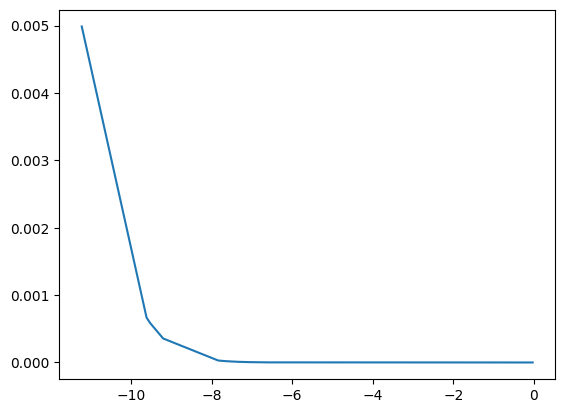

In [35]:
logXarray = np.linspace(logX_l[-1], 0, 1000)
Xarray = np.exp(logXarray)
Larray = np.exp(middle.func(Xarray, theta_true))
plot_points(L, X, ndead)
plt.plot(Xarray, Larray, color='deepskyblue')
plt.plot(X_mean, L, color='black')
plt.plot(X_l[ndead:], L[ndead:], color='orange')
plt.plot(Xarray, np.exp(middle.func(Xarray, theta_l)), color='darkorange')
plt.title(f"nlive={nlive}, ndead={ndead}, $theta$={np.round(theta_l, 2)}");
plt.xlim(-1e-7, 1e-3);

In [ ]:
logZmeans = []
logZsmooths = []
logZmeans_std = []
logZsmooths_std = []
ndeads = np.arange(100, 1000, 100)
for ndead in ndeads:
    ndead = 5000
    nlive = 500
    nk = nk_dead_live(nlive, ndead)
    X_mean = X_mu(nk)
    logX_mean = logX_mu(nk)
    logZmean_i = []
    logZsmooth_i = []
    for _ in range(20):
        X = generate_Xs(nk)
        Xdead, Xlive = X[:ndead], X[ndead:]
        logX = np.log(X)
        theta_true = [10, 0.1]
        logL = middle.func(X, theta_true)
        L = np.exp(logL)
        Ldead, Llive = L[:ndead], L[ndead:]
        
        ls = LS(logL[ndead:], middle, X_mean[ndead:])
        theta_l = ls.minimise(theta_true)
        X_l = middle.inverse(logL, theta_l)
        logX_l = np.log(X_l)

        Zdead = Z(Ldead, X_mean[:ndead])
        Zlive_mean = Z(Llive, X_mean[ndead:])
        Zlive_smooth = quad(gaussian_L, 0, Xlive[0], theta_l)[0]
        logZmean_i.append(np.log(Zdead + Zlive_mean))
        logZsmooth_i.append(np.log(Zdead + Zlive_smooth))


In [36]:
logXarray = np.linspace(logX_l[-1], 0, 1000)
Xarray = np.exp(logXarray)
Larray = np.exp(middle.func(Xarray, theta_true))
plot_points(L, X, ndead)
plt.plot(Xarray, Larray, color='deepskyblue')
plt.plot(X_mean, L, color='black')
plt.plot(X_l[ndead:], L[ndead:], color='orange')
plt.plot(Xarray, np.exp(middle.func(Xarray, theta_l)), color='darkorange')
plt.title(f"nlive={nlive}, ndead={ndead}, $theta$={np.round(theta_l, 2)}");
plt.xlim(-1e-7, 1e-3);

NameError: name 'logX_l' is not defined

### **Plot contribution to Z = LX as a function of X**

##### Generated NS run

In [113]:
nk = nk_dead_live(50, 100)
X_mean = X_mu(nk)
covinv_X = X_Sigmainv(nk)

In [116]:
X = generate_Xs(nk)
theta_true = [10, 0.1]
logL = middle.func(X, theta_true)
L = np.exp(logL)

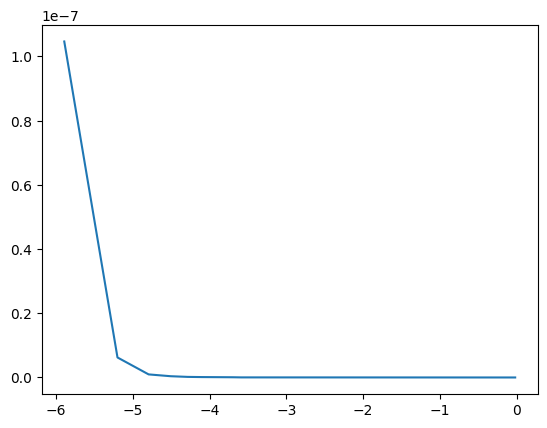

In [118]:
plt.plot(np.log(X_mean), L)
# plt.plot(np.log(mean_X), L*mean_X)

##### Now using real NS runs

In [3]:
logX = samples_g_1.logX()
X = np.exp(logX)
logL = samples_g_1.logL
L = np.exp(logL)

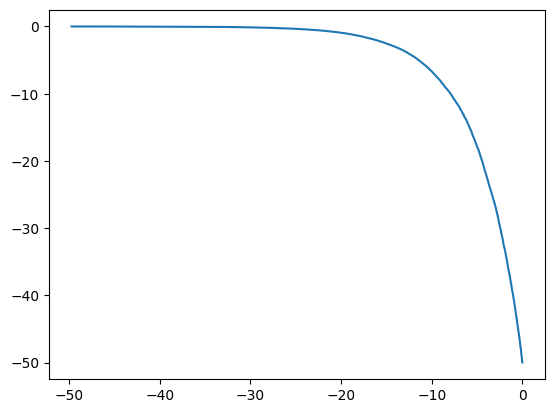

In [4]:
plt.plot(logX, logL)

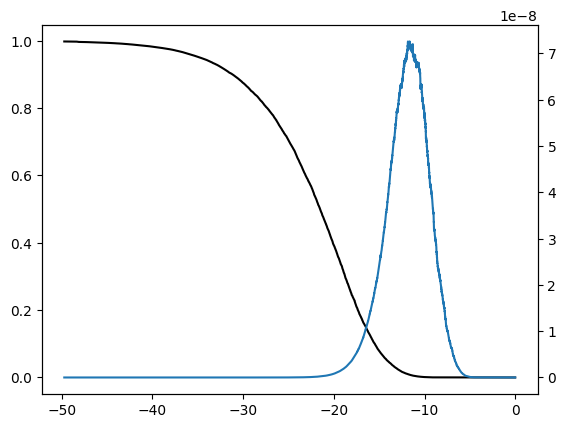

In [5]:
fig, ax1 = plt.subplots()
ax1.plot(logX, L, color='black')
ax2 = ax1.twinx()
ax2.plot(logX, L*X)

In [40]:
Z_true = np.trapz(L, X)
Z_mean = np.trapz(L, X_mean)
Z_l = np.trapz(L, X_l)
print(np.round(Z_true, 3))
print(np.round(Z_mean, 3))
print(np.round(Z_l, 3))

-0.408
-0.424
-0.417


In [131]:
nk = nk_live(500)
X_mean = X_mu(nk)
covinv_X = X_Sigmainv(nk)

mean wins
true -0.437
mean -0.439
smooth -0.439


(0.4, 0.5)

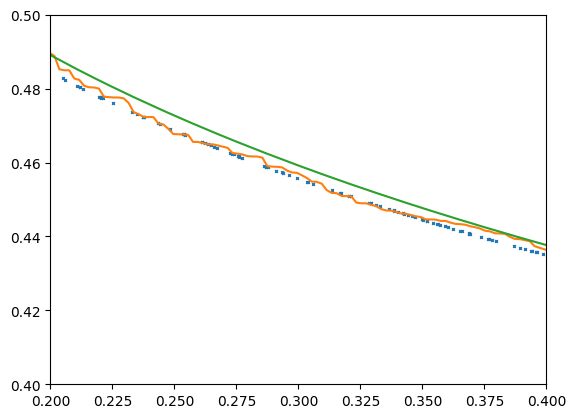

In [133]:
X = generate_Xs(nk)
theta_true = 10
logL = simple.func(X, theta_true)
L = np.exp(logL)
ls = LS(logL, simple, X_mean, covinv_X)
theta_l = ls.minimise(theta_true)
X_l = simple.inverse(logL, theta_l)
Z_true = np.trapz(L, X)
Z_mean = np.trapz(L, X_mean)
Z_l = np.trapz(L, X_l)
if abs(Z_true - Z_mean) < abs(Z_true - Z_l):
    print('mean wins')
else:
    print('smooth wins')
print('true', np.round(Z_true, 3))
print('mean', np.round(Z_mean, 3))
print('smooth', np.round(Z_l, 3))
plt.plot(X, L, 'x', ms=2)
plt.plot(X_mean, L)
plt.plot(X_l, L)
plt.xlim(0.2, 0.4)
plt.ylim(0.4, 0.5)

In [125]:
smooth = 0
mean = 0
for i in range(1000):
    X = generate_Xs(nk)
    theta_true = 10
    logL = simple.func(X, theta_true)
    L = np.exp(logL)
    ls = LS(logL, simple, X_mean, covinv_X)
    theta_l = ls.minimise(theta_true)
    X_l = simple.inverse(logL, theta_l)
    Z_true = np.trapz(L, X)
    Z_mean = np.trapz(L, X_mean)
    Z_l = np.trapz(L, X_l)
    if abs(Z_true - Z_mean) < abs(Z_true - Z_l):
        mean += 1
    else:
        smooth += 1
print('smooth', smooth)
print('mean', mean)


smooth 465
mean 535
